### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

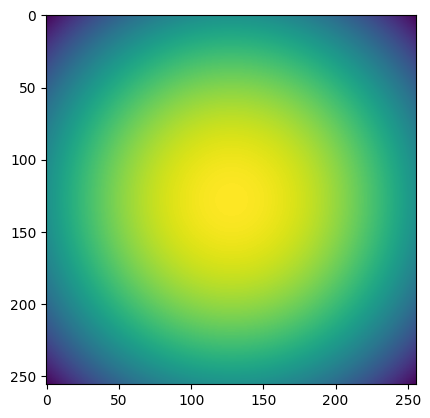

In [8]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 256 #[256, 512, 1024]



##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [9]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5

##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

$$
F_N /\left(E^* L^2 h^\prime_{\mathrm{rms}}\right)
$$

In [10]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)

p_target = p_target / (E_star*h_rms_prime)

Fn_Johnson = W / (E_star*h_rms_prime)

#solver.solve(p_target)
time_steps_list = [20, 30, 50, 80, 100, 150, 250, 400, 800]
L2_norms = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 10/np.min(characteristic_time)



In [11]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for t in np.linspace(t0, t1, time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * Fn_Johnson * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    print(Ac_tamaas)
    print(Ac_Johnson_ref)
    print(len(Ac_tamaas))
    print(len(Ac_Johnson_ref))

    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))

    # normalize L2 error
    L2_error /= np.sqrt(len(Ac_tamaas))

    L2_norms.append(L2_error)


 Iter          Cost_f           Error
    0    1.673549e-06    5.270389e-01


   32    2.509214e-04    5.787383e-13
 Iter          Cost_f           Error
    0    1.198344e-04    2.784076e-04
   20    3.108735e-04    1.052517e-13
 Iter          Cost_f           Error
    0    1.520001e-04    1.930259e-04
   19    3.556497e-04    5.068633e-13
 Iter          Cost_f           Error
    0    1.766081e-04    1.289030e-04
   14    3.897670e-04    2.908274e-13
 Iter          Cost_f           Error
    0    1.953002e-04    1.063973e-04
   13    4.158889e-04    3.296317e-13
 Iter          Cost_f           Error
    0    2.095763e-04    6.971483e-05
   13    4.359933e-04    3.624326e-13
 Iter          Cost_f           Error
    0    2.206598e-04    4.589740e-05
   14    4.516329e-04    3.430083e-13
 Iter          Cost_f           Error
    0    2.293077e-04    4.827763e-05
   14    4.638897e-04    5.060168e-13
 Iter          Cost_f           Error
    0    2.359969e-04    3.202819e-05
   13    4.734644e-04    4.246982e-13
 Iter          Cost_f           Error
    0    2.4

[np.float64(0.0011138916015625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125)]
[np.float64(0.0011481433842656893), np.float64(0.0012537282004770561), np.float64(0.0013329623680864852), np.float64(0.0013930710696336897), np.float64(0.0014389986226841958), np.float64(0.0014742649035556542), np.float64(0.001501440545676146), np.float64(0.0015224356734764848), np.float64(0.0015386869015181995), np.float64(0.001551284144602309), np.float64(0.0015610595594393927), np.floa

 Iter          Cost_f           Error
    0    2.148261e-04    6.981785e-05
   13    4.454485e-04    5.409520e-13
 Iter          Cost_f           Error
    0    2.259573e-04    5.168678e-05
   13    4.610797e-04    8.224987e-13
 Iter          Cost_f           Error
    0    2.352129e-04    3.838451e-05
   13    4.741781e-04    3.194229e-13
 Iter          Cost_f           Error
    0    2.430157e-04    2.855715e-05
   14    4.852166e-04    2.228128e-13
 Iter          Cost_f           Error
    0    2.496160e-04    3.495609e-05
   13    4.945592e-04    5.488341e-13
 Iter          Cost_f           Error
    0    2.551283e-04    2.611442e-05
   13    5.024288e-04    7.816309e-13
 Iter          Cost_f           Error
    0    2.597565e-04    1.952809e-05
   13    5.090741e-04    5.476651e-13
 Iter          Cost_f           Error
    0    2.636528e-04    1.461359e-05
   13    5.146973e-04    4.585323e-13
 Iter          Cost_f           Error
    0    2.669406e-04    1.094193e-05
   12    5.1

[np.float64(0.0010528564453125), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125)]
[np.float64(0.0011053201888309302), np.float64(0.001186848545446431), n

 Iter          Cost_f           Error
    0    1.927512e-04    6.667534e-05
   11    4.176392e-04    5.805439e-13
 Iter          Cost_f           Error
    0    2.051619e-04    5.451663e-05
   14    4.345379e-04    1.095730e-13
 Iter          Cost_f           Error
    0    2.161396e-04    6.063715e-05
   13    4.497064e-04    2.253125e-13
 Iter          Cost_f           Error
    0    2.258864e-04    4.991792e-05
   13    4.631897e-04    8.763829e-13
 Iter          Cost_f           Error
    0    2.345171e-04    4.117256e-05
   13    4.752086e-04    2.110217e-13
 Iter          Cost_f           Error
    0    2.421822e-04    3.401483e-05
   13    4.859478e-04    5.681884e-13
 Iter          Cost_f           Error
    0    2.490070e-04    2.814040e-05
   12    4.955628e-04    9.051470e-13
 Iter          Cost_f           Error
    0    2.550970e-04    2.330777e-05
   13    5.041860e-04    5.045111e-13
 Iter          Cost_f           Error
    0    2.605415e-04    1.932415e-05
   12    5.1

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.floa

 Iter          Cost_f           Error
    0    1.779192e-04    5.902542e-05
   12    3.990676e-04    4.796437e-13
 Iter          Cost_f           Error
    0    1.882701e-04    5.167813e-05
   12    4.131901e-04    4.041560e-13
 Iter          Cost_f           Error
    0    1.977846e-04    4.531278e-05
   12    4.262474e-04    4.910977e-13
 Iter          Cost_f           Error
    0    2.065485e-04    3.978552e-05
   12    4.383403e-04    3.255049e-13
 Iter          Cost_f           Error
    0    2.147230e-04    3.496240e-05
   17    4.495569e-04    6.203527e-13
 Iter          Cost_f           Error
    0    2.223773e-04    3.608722e-05
   13    4.600636e-04    5.960459e-13
 Iter          Cost_f           Error
    0    2.294727e-04    3.695523e-05
   12    4.698321e-04    9.877212e-13
 Iter          Cost_f           Error
    0    2.360351e-04    3.258638e-05
   12    4.788948e-04    8.776369e-13
 Iter          Cost_f           Error
    0    2.421023e-04    2.875811e-05
   12    4.8

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.floa

    0    1.741785e-04    5.154335e-05
   12    3.947128e-04    4.015452e-13
 Iter          Cost_f           Error
    0    1.832252e-04    4.623851e-05
   12    4.069859e-04    3.650560e-13
 Iter          Cost_f           Error
    0    1.916627e-04    4.152337e-05
   12    4.184918e-04    3.338638e-13
 Iter          Cost_f           Error
    0    1.995442e-04    3.732568e-05
   12    4.292919e-04    3.099571e-13
 Iter          Cost_f           Error
    0    2.069167e-04    3.358299e-05
   12    4.394409e-04    3.098263e-13
 Iter          Cost_f           Error
    0    2.138220e-04    3.024119e-05
   12    4.489879e-04    4.341643e-13
 Iter          Cost_f           Error
    0    2.203698e-04    2.724428e-05
   17    4.579770e-04    4.921404e-13
 Iter          Cost_f           Error
    0    2.265973e-04    2.956479e-05
   13    4.665243e-04    4.215105e-13
 Iter          Cost_f           Error
    0    2.324597e-04    3.031187e-05
   12    4.745846e-04    7.487693e-13
 Iter       

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.floa

 Iter          Cost_f           Error
    0    1.573487e-04    4.008008e-05
   13    3.731160e-04    2.518403e-13
 Iter          Cost_f           Error
    0    1.646343e-04    4.026242e-05
   12    3.829458e-04    3.436652e-13
 Iter          Cost_f           Error
    0    1.716281e-04    3.735814e-05
   12    3.923336e-04    3.276361e-13
 Iter          Cost_f           Error
    0    1.782857e-04    3.468234e-05
   12    4.013061e-04    3.209997e-13
 Iter          Cost_f           Error
    0    1.846287e-04    3.221506e-05
   12    4.098875e-04    2.891852e-13
 Iter          Cost_f           Error
    0    1.906766e-04    2.993827e-05
   12    4.181002e-04    2.722927e-13
 Iter          Cost_f           Error
    0    1.964477e-04    2.783567e-05
   12    4.259648e-04    3.036808e-13
 Iter          Cost_f           Error
    0    2.019585e-04    2.589251e-05
   12    4.335005e-04    3.593076e-13
 Iter          Cost_f           Error
    0    2.072243e-04    2.409543e-05
   12    4.4

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.floa

 Iter          Cost_f           Error
    0    1.250574e-04    2.234693e-05
   11    3.305274e-04    8.512689e-14
 Iter          Cost_f           Error
    0    1.302573e-04    2.134004e-05
   12    3.377001e-04    8.874092e-13
 Iter          Cost_f           Error
    0    1.354375e-04    3.050240e-05
   17    3.447662e-04    6.849093e-13
 Iter          Cost_f           Error
    0    1.406336e-04    2.913056e-05
   13    3.517055e-04    2.110736e-13
 Iter          Cost_f           Error
    0    1.456517e-04    2.791566e-05
   12    3.584954e-04    8.547277e-14
 Iter          Cost_f           Error
    0    1.505556e-04    2.666319e-05
   12    3.650988e-04    8.216793e-14
 Iter          Cost_f           Error
    0    1.553504e-04    2.546972e-05
   17    3.715225e-04    4.313471e-13
 Iter          Cost_f           Error
    0    1.600953e-04    2.431172e-05
   13    3.778065e-04    1.776269e-13
 Iter          Cost_f           Error
    0    1.646631e-04    2.514815e-05
   12    3.8

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.floa

 Iter          Cost_f           Error
    0    1.166781e-04    1.525783e-05
   10    3.192386e-04    5.939142e-13
 Iter          Cost_f           Error
    0    1.201357e-04    1.481948e-05
   11    3.240336e-04    4.921051e-14
 Iter          Cost_f           Error
    0    1.235331e-04    1.439501e-05
   10    3.287518e-04    5.200434e-13
 Iter          Cost_f           Error
    0    1.268718e-04    1.398393e-05
   11    3.333948e-04    4.687600e-14
 Iter          Cost_f           Error
    0    1.301531e-04    1.358577e-05
   10    3.379642e-04    4.572638e-13
 Iter          Cost_f           Error
    0    1.334250e-04    1.319648e-05
   12    3.424728e-04    3.311556e-13
 Iter          Cost_f           Error
    0    1.366898e-04    1.919820e-05
   12    3.469505e-04    5.924468e-14
 Iter          Cost_f           Error
    0    1.399522e-04    1.866228e-05
   16    3.513540e-04    5.249320e-13
 Iter          Cost_f           Error
    0    1.432238e-04    1.812524e-05
   12    3.5

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.floa

 Iter          Cost_f           Error
    0    9.501553e-05    9.176337e-06
   10    2.897027e-04    3.015435e-13
 Iter          Cost_f           Error
    0    9.698545e-05    9.039858e-06
   11    2.924058e-04    2.905377e-14
 Iter          Cost_f           Error
    0    9.893713e-05    8.905633e-06
   10    2.950861e-04    2.341532e-13
 Iter          Cost_f           Error
    0    1.008708e-04    8.773620e-06
   11    2.977438e-04    2.840132e-14
 Iter          Cost_f           Error
    0    1.027868e-04    8.643778e-06
   10    3.003792e-04    2.161480e-13
 Iter          Cost_f           Error
    0    1.046852e-04    8.516068e-06
   11    3.029927e-04    2.765124e-14
 Iter          Cost_f           Error
    0    1.065663e-04    8.390449e-06
   10    3.055844e-04    2.382797e-13
 Iter          Cost_f           Error
    0    1.084303e-04    8.266884e-06
   11    3.081545e-04    2.699281e-14
 Iter          Cost_f           Error
    0    1.102775e-04    8.145335e-06
   10    3.1

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

In [12]:
print(L2_norms)

[np.float64(6.0285771459618135e-05), np.float64(7.123128020116855e-05), np.float64(6.866259576126104e-05), np.float64(6.794745338438686e-05), np.float64(6.941879926189533e-05), np.float64(7.044786327919554e-05), np.float64(7.093824225351498e-05), np.float64(7.157072738135097e-05), np.float64(7.149389416384876e-05)]


[np.float64(0.5), np.float64(0.3333333333333333), np.float64(0.2), np.float64(0.125), np.float64(0.1), np.float64(0.06666666666666667), np.float64(0.04), np.float64(0.025), np.float64(0.0125)]


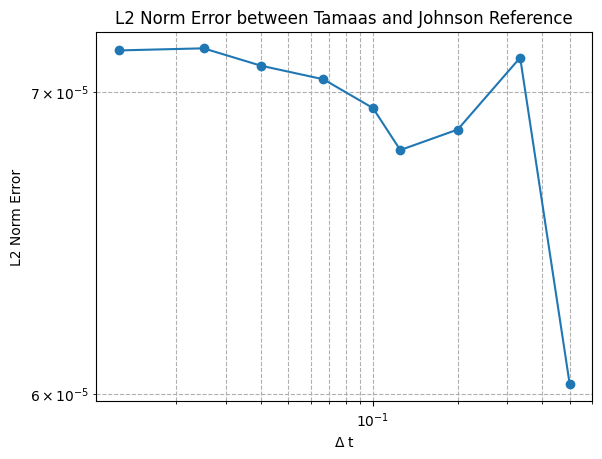

In [15]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, L2_norms, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.show()